# Initialization
---
- example data (Heidi 2003 exampel data, 1 day Synechococcus)

In [1]:
setwd("/Users/francois/Documents/DATA/Codes/ssPopModel")


library(R.matlab)
library(seewave)
df <- readMat("inst/sosik2003/day733320data.mat") # load 1 day of observed Synechococcus size distribution (from SOSIK et al. 2003)

time <- seq(0,1+3600*24,by=3600)
volbins <- (df$volbins) 
V.hists <- df$Vhists
	colnames(V.hists) <- time
	row.names(V.hists) <- volbins
N.dist <- df$N.dist
	colnames(N.dist) <- time
	row.names(N.dist) <- volbins
	Ntot <- colSums(N.dist)
Edata <- df$Edata
	Edata[,1] <- seq(range(time)[1], range(time)[2], length.out=nrow(Edata))


results <- readMat("inst/sosik2003/results.mat") # load results (from SOSIK et al. 2003)
	Vproj <- results$Vproj
	colnames(Vproj) <- time
	row.names(Vproj) <- volbins

	params <- results$modelresults[-1]
	gmax <- params[1]
	a <- params[2]
	b <- params[3]
	E_star <- params[4]
	dmax <- params[5]
	c <- 1.5

	hr <- 1


######
library(DEoptim)
library(cmaes) 
        
        resol <- 10
		dt <- resol/60
		time.interval <- median(diff(as.numeric(colnames(V.hists))))
		# dt <- 1/6; breaks <- 25 ## MATLAB
		ti <- as.numeric(colnames(V.hists))

		# create Light data with 'dt' time interval.
			seq <- NULL
			for(i in 1:(length(ti)-1)){
				s <- seq(ti[i], ti[i+1], length.out=1/dt)
				seq <- c(seq, s)
			}

		ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
		Einterp <- ep$y
		Einterp[Einterp < 0] <- 0

R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Warning message:
"package 'seewave' was built under R version 3.5.2"Loading required package: parallel

DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich



- $Sigma$ function for sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$


In [2]:
###############
## sigma.lsq ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.lsq <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, dim[1], dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]), resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  (N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))^2 # ABSOLUTE observed value - fitted value
					}
			sigma <- colSums(sigma)/colSums(N.dist[,-1])
			sigma <- mean(sigma, na.rm=T)
			return(sigma)

}

- $Sigma$ function for Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [3]:
###############
## sigma.kl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.kl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]), resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  seewave::kl.dist(N.dist[, hr+1],round(TotN[hr+1]*wt.norm))$D1
                    }
			sigma <- sum(sigma, na.rm=T)
			return(sigma)

}


# 1. Original model
---

## 1a. Load matrix model

In [11]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 0
        resp <-  rep(mean(y) + 0.3, length(y)) # proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 1b. Optimization 
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [5]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax <- params[1]
		dmax <- params[2]
		b <- params[3]
		E_star <- params[4]
		resnorm <- opt$optim$bestval

Iteration: 10 bestvalit: 5.751331 bestmemit:    0.122671    0.028181    4.136292  365.465619
Iteration: 20 bestvalit: 5.137942 bestmemit:    0.163175    0.028181    4.136292  269.977263
Iteration: 30 bestvalit: 5.025603 bestmemit:    0.160791    0.038705    3.968873  196.091292
Iteration: 40 bestvalit: 4.979556 bestmemit:    0.167401    0.036260    4.009392  251.613966
Iteration: 50 bestvalit: 4.979556 bestmemit:    0.167401    0.036260    4.009392  251.613966
Iteration: 60 bestvalit: 4.975561 bestmemit:    0.167401    0.036974    4.042695  247.957809
Iteration: 70 bestvalit: 4.973723 bestmemit:    0.169344    0.037146    4.055510  251.492247
Iteration: 80 bestvalit: 4.973723 bestmemit:    0.169344    0.037146    4.055510  251.492247
Iteration: 90 bestvalit: 4.973723 bestmemit:    0.169344    0.037146    4.055510  251.492247
Iteration: 100 bestvalit: 4.973161 bestmemit:    0.167401    0.036974    4.042695  250.759204
Iteration: 110 bestvalit: 4.973161 bestmemit:    0.167401    0.036974

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [7]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax. <- params[1]
		dmax. <- params[2]
		b. <- params[3]
		E_star. <- params[4]
		resnorm. <- opt$optim$bestval

Iteration: 10 bestvalit: 0.257930 bestmemit:    0.154490    0.021236    2.582265  189.146547
Iteration: 20 bestvalit: 0.237030 bestmemit:    0.176108    0.043267    4.142018  189.573183
Iteration: 30 bestvalit: 0.232209 bestmemit:    0.169610    0.031891    3.839056  202.927995
Iteration: 40 bestvalit: 0.230326 bestmemit:    0.168235    0.031149    3.869554  250.828526
Iteration: 50 bestvalit: 0.230124 bestmemit:    0.169610    0.031891    3.839056  254.600955
Iteration: 60 bestvalit: 0.230103 bestmemit:    0.171357    0.033324    3.970828  258.865483
Iteration: 70 bestvalit: 0.229993 bestmemit:    0.169312    0.031689    3.889742  257.599982
Iteration: 80 bestvalit: 0.229827 bestmemit:    0.168924    0.031689    3.889742  257.599982
Iteration: 90 bestvalit: 0.229827 bestmemit:    0.168924    0.031689    3.889742  257.599982
Iteration: 100 bestvalit: 0.229803 bestmemit:    0.168852    0.031502    3.882545  258.002099
Iteration: 110 bestvalit: 0.229795 bestmemit:    0.169056    0.031613

## 1c. Results

In [8]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj <- Vproj. <- V.hists
Nproj <- Nproj. <- N.dist
mu_N <- mu_N. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star, resol=resol)
        Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
	    Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
		Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
		mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
					    ((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
            		    
      B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax., dmax=dmax.,b=b., E_star=E_star., resol=resol)
      Nproj.[,hr+1] <- round(B. %*% Nproj.[,hr]) # calculate numbers of individuals
      Vproj.[,hr+1] <- B. %*% Vproj.[,hr] # calculate the projected size-frequency distribution
	    Vproj.[,hr+1] <- Vproj.[,hr+1]/sum(Vproj.[,hr+1]) # normalize distribution so sum = 1
		mu_N.[,hr+1] <- log(sum(Nproj.[,hr+1])/sum(Nproj.[,hr]))/
					    ((as.numeric(colnames(Nproj.)[hr+1])-as.numeric(colnames(Nproj.)[hr]))/(time.interval))
				
    }

Nproj <- colSums(Nproj)
colnames(mu_N) <- colnames(Vproj)
Nproj. <- colSums(Nproj.)
colnames(mu_N.) <- colnames(Vproj.)

#############################
## Growth rate calculation ##
#############################
d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)
d.mu_N. <- 24*mean(mu_N.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2),"-",round(d.mu_N.,2)))


[1] "daily growth rate= 0.75 - 0.71"


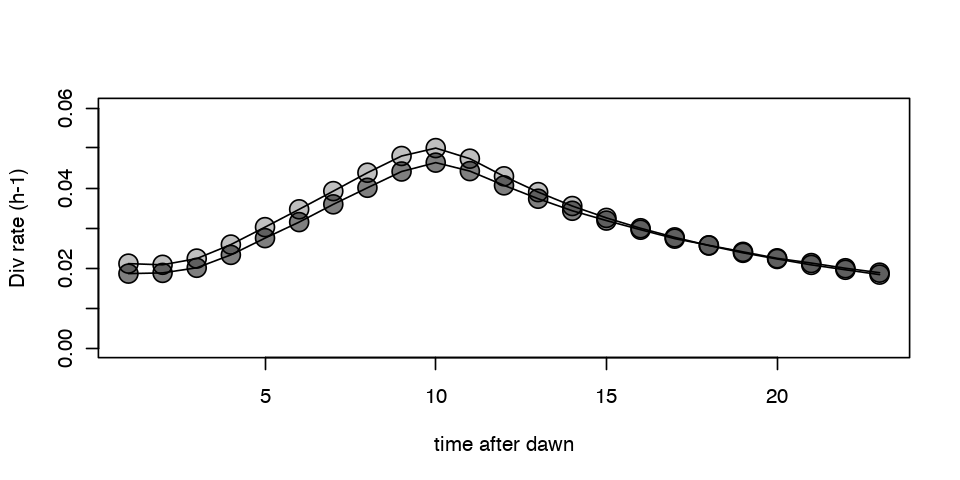

In [9]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

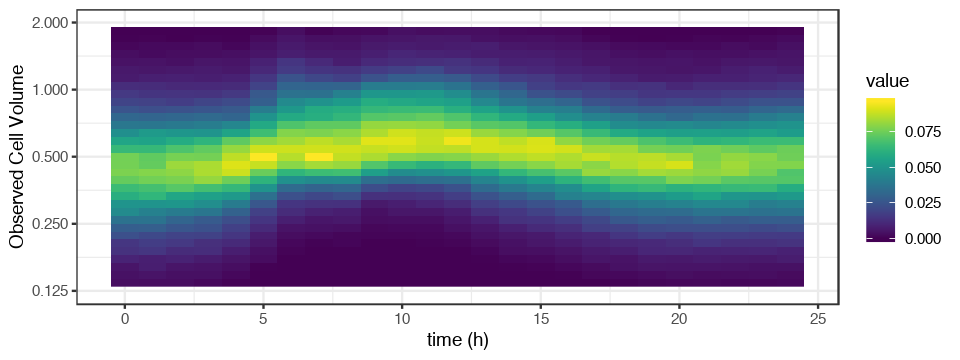

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

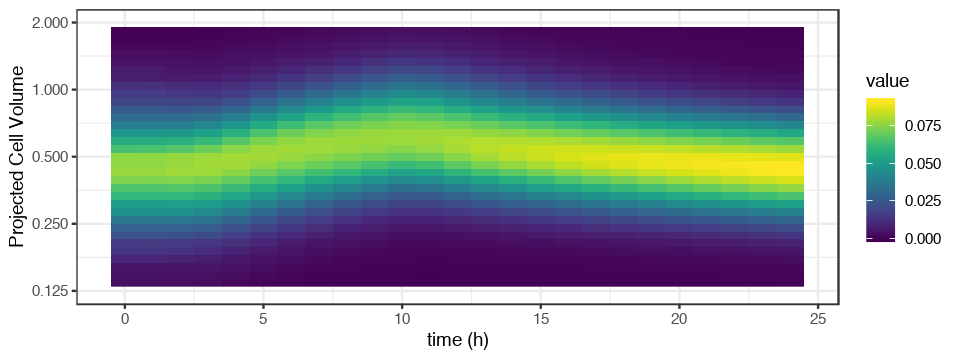

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

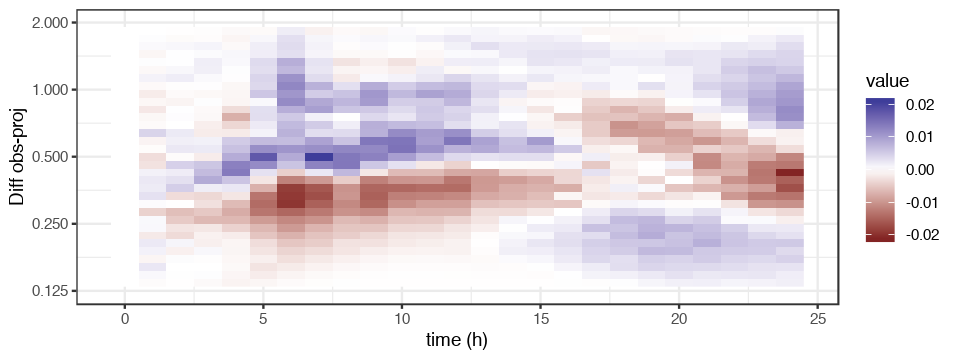

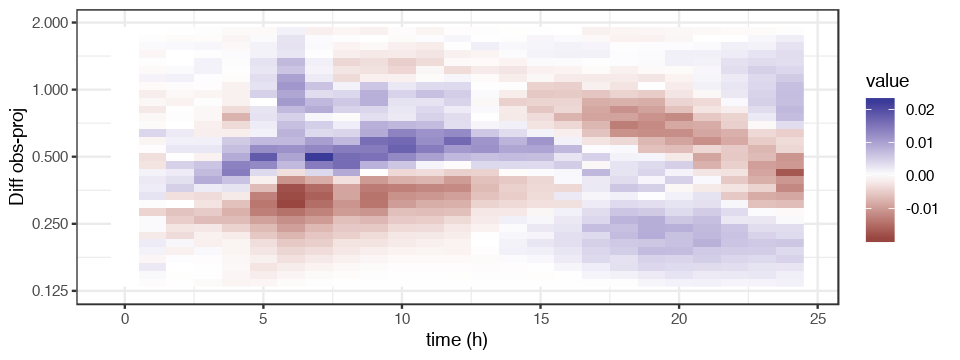

In [10]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Projected Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(V.hists- Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)
ggplot(melt(V.hists- Vproj.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') +  scale_fill_gradient2(midpoint=0)

# 2. Model with Respiration
---


## 2a. Load matrix model

In [21]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 1
        resp <-  rep(mean(y) * 0.3, length(y)) # proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 2b. Optimization
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [22]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2 <- params[1]
		dmax2 <- params[2]
		b2 <- params[3]
		E_star2 <- params[4]
		resnorm2 <- opt$optim$bestval

Iteration: 10 bestvalit: 5.790670 bestmemit:    0.128048    0.046363    5.699758   91.033717
Iteration: 20 bestvalit: 4.867948 bestmemit:    0.153220    0.033154    4.811437  229.540026
Iteration: 30 bestvalit: 4.799105 bestmemit:    0.154189    0.031326    4.281712  241.031214
Iteration: 40 bestvalit: 4.796696 bestmemit:    0.156911    0.033023    4.200049  243.973558
Iteration: 50 bestvalit: 4.792329 bestmemit:    0.160103    0.032504    4.254515  256.131389
Iteration: 60 bestvalit: 4.788233 bestmemit:    0.160904    0.032505    4.249967  256.445980
Iteration: 70 bestvalit: 4.788233 bestmemit:    0.160904    0.032505    4.249967  256.445980
Iteration: 80 bestvalit: 4.788059 bestmemit:    0.159294    0.032645    4.244343  256.687198
Iteration: 90 bestvalit: 4.788059 bestmemit:    0.159294    0.032645    4.244343  256.687198
Iteration: 100 bestvalit: 4.788059 bestmemit:    0.159294    0.032645    4.244343  256.687198
Iteration: 110 bestvalit: 4.788059 bestmemit:    0.159294    0.032645

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [23]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2. <- params[1]
		dmax2. <- params[2]
		b2. <- params[3]
		E_star2. <- params[4]
		resnorm2. <- opt$optim$bestval

Iteration: 10 bestvalit: 0.263978 bestmemit:    0.138019    0.043806    6.200960  144.146202
Iteration: 20 bestvalit: 0.233459 bestmemit:    0.207023    0.040021    4.627102  307.638511
Iteration: 30 bestvalit: 0.223371 bestmemit:    0.161151    0.031694    4.020783  251.461670
Iteration: 40 bestvalit: 0.221401 bestmemit:    0.167387    0.028300    4.144280  257.944328
Iteration: 50 bestvalit: 0.221252 bestmemit:    0.166193    0.029677    4.132385  256.797616
Iteration: 60 bestvalit: 0.221031 bestmemit:    0.164985    0.029475    4.136860  259.551019
Iteration: 70 bestvalit: 0.220924 bestmemit:    0.164985    0.029475    4.136860  258.718678
Iteration: 80 bestvalit: 0.220822 bestmemit:    0.165108    0.029655    4.140492  258.512921
Iteration: 90 bestvalit: 0.220822 bestmemit:    0.165108    0.029655    4.140492  258.512921
Iteration: 100 bestvalit: 0.220798 bestmemit:    0.165140    0.029706    4.143470  258.807189
Iteration: 110 bestvalit: 0.220798 bestmemit:    0.165140    0.029706

## 2c. Results

In [24]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj2 <- Vproj2. <- V.hists
Nproj2 <- Nproj2. <- N.dist
mu_N2 <- mu_N2. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
	B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2, dmax=dmax2,b=b2, E_star=E_star2, resol=resol)
    Nproj2[,hr+1] <- round(B %*% Nproj2[,hr]) # calculate numbers of individuals
	Vproj2[,hr+1] <- B %*% Vproj2[,hr] # calculate the projected size-frequency distribution
	Vproj2[,hr+1] <- Vproj2[,hr+1]/sum(Vproj2[,hr+1]) # normalize distribution so sum = 1
	mu_N2[,hr+1] <- log(sum(Nproj2[,hr+1])/sum(Nproj2[,hr]))/
					((as.numeric(colnames(Nproj2)[hr+1])-as.numeric(colnames(Nproj2)[hr]))/(time.interval))
            		    
  B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2., dmax=dmax2.,b=b2., E_star=E_star2., resol=resol)
  Nproj2.[,hr+1] <- round(B. %*% Nproj2.[,hr]) # calculate numbers of individuals
	Vproj2.[,hr+1] <- B. %*% Vproj2.[,hr] # calculate the projected size-frequency distribution
	Vproj2.[,hr+1] <- Vproj2.[,hr+1]/sum(Vproj2.[,hr+1]) # normalize distribution so sum = 1
	mu_N2.[,hr+1] <- log(sum(Nproj2.[,hr+1])/sum(Nproj2.[,hr]))/
					((as.numeric(colnames(Nproj2.)[hr+1])-as.numeric(colnames(Nproj2.)[hr]))/(time.interval))
						
    }

Nproj2 <- colSums(Nproj2)
colnames(mu_N2) <- colnames(Vproj2)
Nproj2. <- colSums(Nproj2.)
colnames(mu_N2.) <- colnames(Vproj2.)

#############################
## Growth rate calculation ##
#############################
d.mu_N2 <- 24*mean(mu_N2[-c(1:2)], na.rm=T)
d.mu_N2. <- 24*mean(mu_N2.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N2,2),"-",round(d.mu_N2.,2)))

[1] "daily growth rate= 0.63 - 0.63"


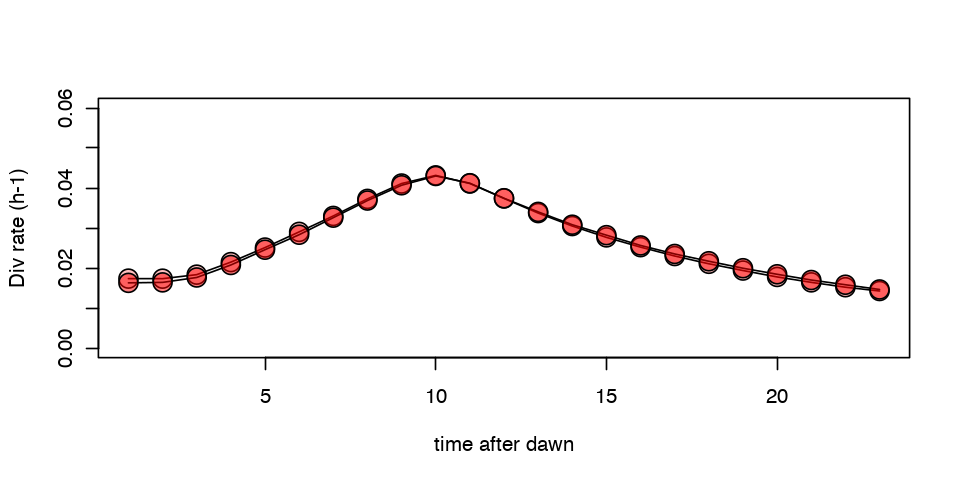

In [25]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N2[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N2.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

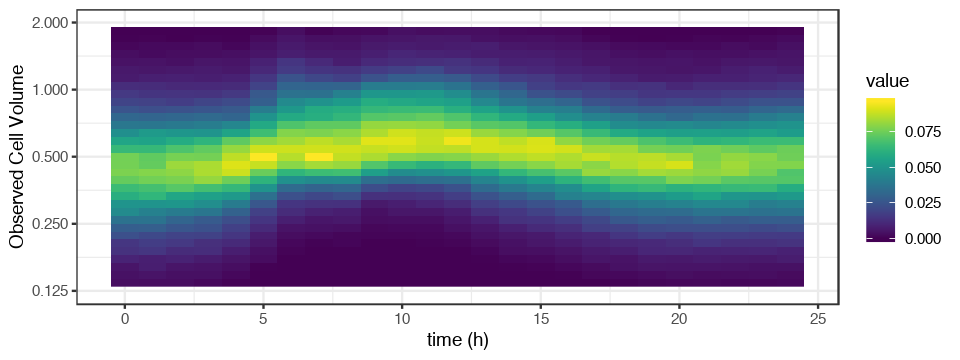

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

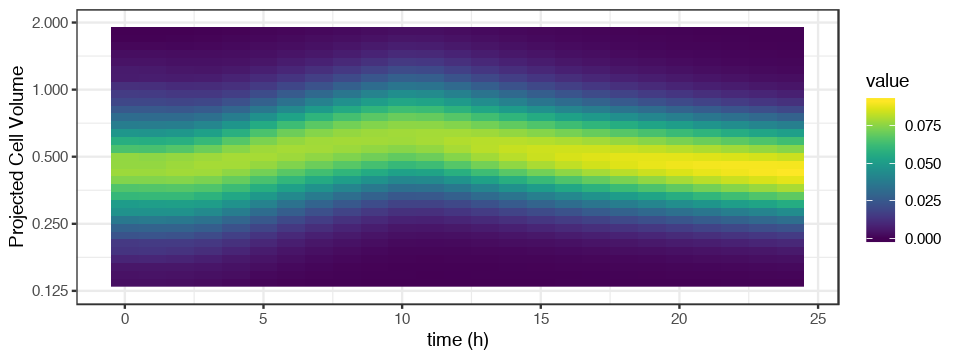

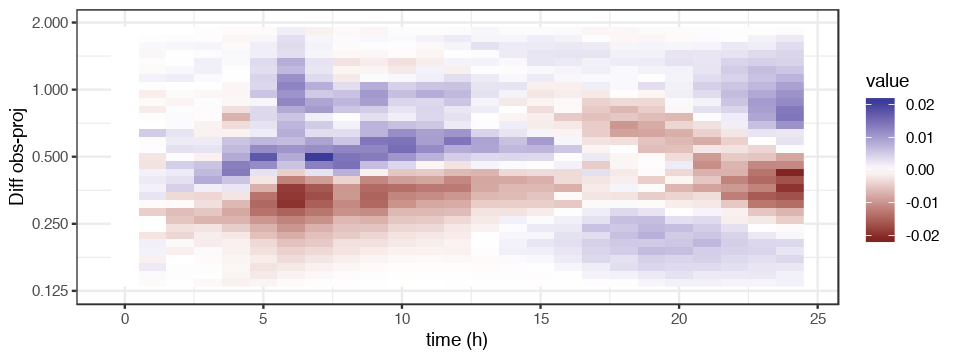

In [26]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Projected Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(V.hists-Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)

# 3. Summary
---

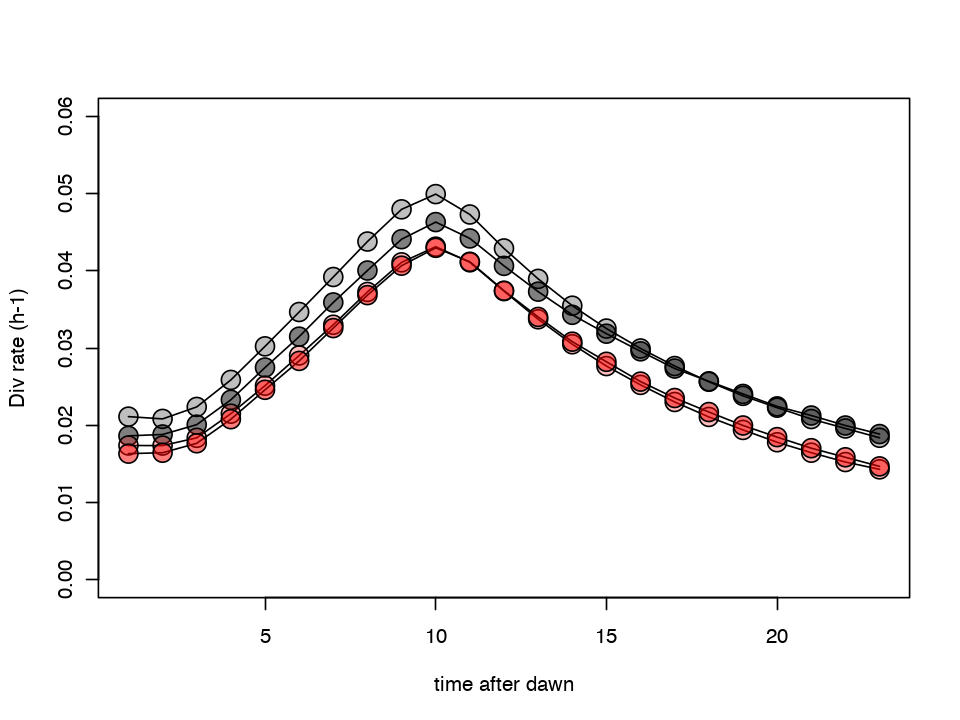

In [27]:
options(repr.plot.width=8, repr.plot.height=6)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))
  points(mu_N2[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N2.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

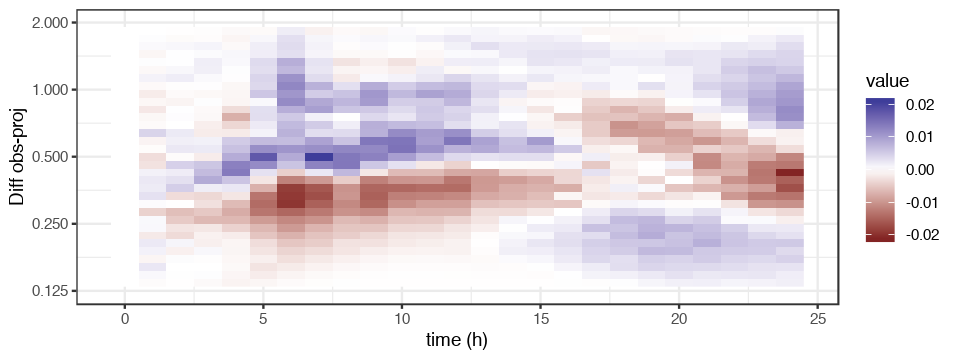

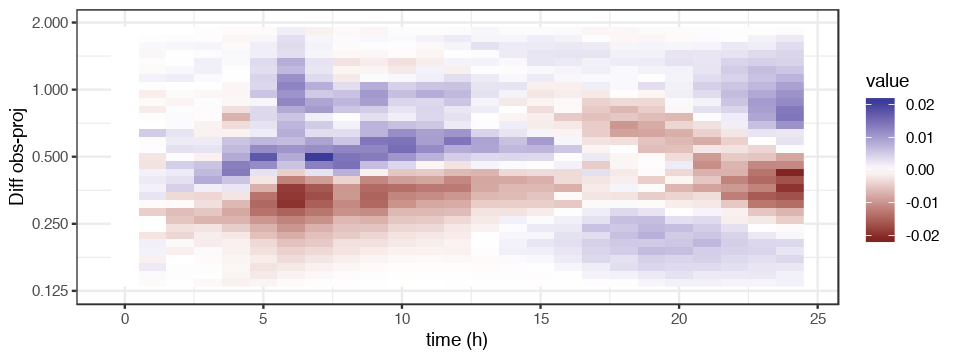

In [28]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists - Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)
ggplot(melt(V.hists - Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

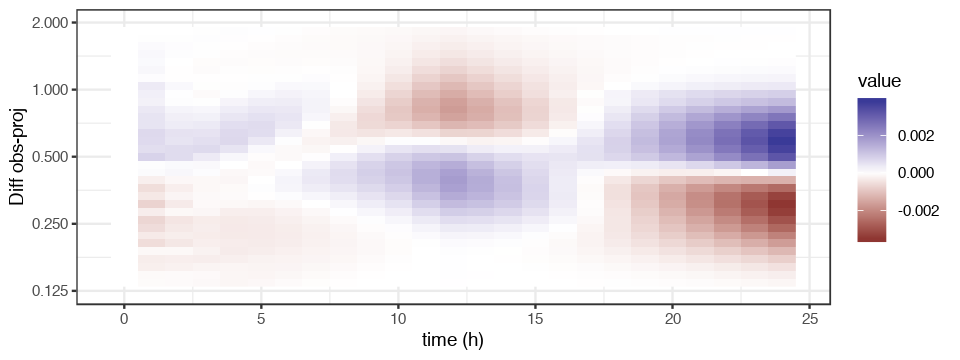

In [29]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(Vproj - Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)